Microsoft Differential Privacy Whitepaper Collateral Notebooks Part 3
# Privacy-Preserving Statistical Analysis with Differential Privacy 

<img src="images/histogram.jpg" width=800 />

The goal of this notebook is to demonstrate how to generate and release basic statistical outcomes in a differntially private fashion. We will assess the impact on various privacy levels and dataset sizes on accuracy.

We are using a dataset conataining demographic data about Californian residents from the Public Use Microdata Sample (PUMS) statistics.
The dataset includes more than 1.2m records and is therefore well suited to experiment with different sample sizes.

The data includes personal information like gender, age, ethnical background, income and marital status. For our analysis, we will focus on creating histograms for the yearly income.

The default method for generating a histogram in SmartNoise is by releasing counts of each bin or category using the geometric mechanism. The geometric mechanism only returns integer values for any query, so resists some vulnerabilities of DP releases from floating point approximations. It is also possible to generate histograms from the more typical Laplace mechanism. We show both approaches below.

## Installs and imports

In [1]:
# %pip install opendp seaborn

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

datafile = os.path.join('.','data','PUMS-california-demographics.csv')
samplefile = os.path.join('.','data','sample.csv') # export generated sample and import for DP analysis

df = pd.read_csv(datafile, usecols = range(1,11))

## Inspect Dataset

In [4]:
df.head(8)

,state,puma,sex,age,educ,income,latino,black,asian,married
0,6,60100,0,83,9,20500.0,0,0,0,1
1,6,60100,1,81,9,4800.0,0,0,0,1
2,6,60100,0,45,9,12000.0,0,0,0,1
3,6,60100,1,42,12,7200.0,0,0,0,1
4,6,60100,0,35,11,55600.0,0,0,0,1
5,6,60100,1,34,11,4600.0,0,0,0,1
6,6,60100,0,20,8,8000.0,1,0,0,0
7,6,60100,0,35,12,43000.0,0,0,0,0


## Preprocess data
Converting the continuous variable income to catagories as foundation for the further analysis.

In [5]:
# remove entries with negative income values
df.drop (df[df['income'] < 0].index, inplace=True)

income_categories = ['less 10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '50k-60k', '60k-80k', '80k-100k', '100k-150k', 'above 150k']
cut_bins = [-1, 10000, 20000, 30000, 40000, 50000, 60000, 80000, 100000, 150000, 1000000] # 10 categories
df['inc_cat'] = pd.cut(df['income'], bins=cut_bins, labels=income_categories)

## Review histogram of income from original dataset

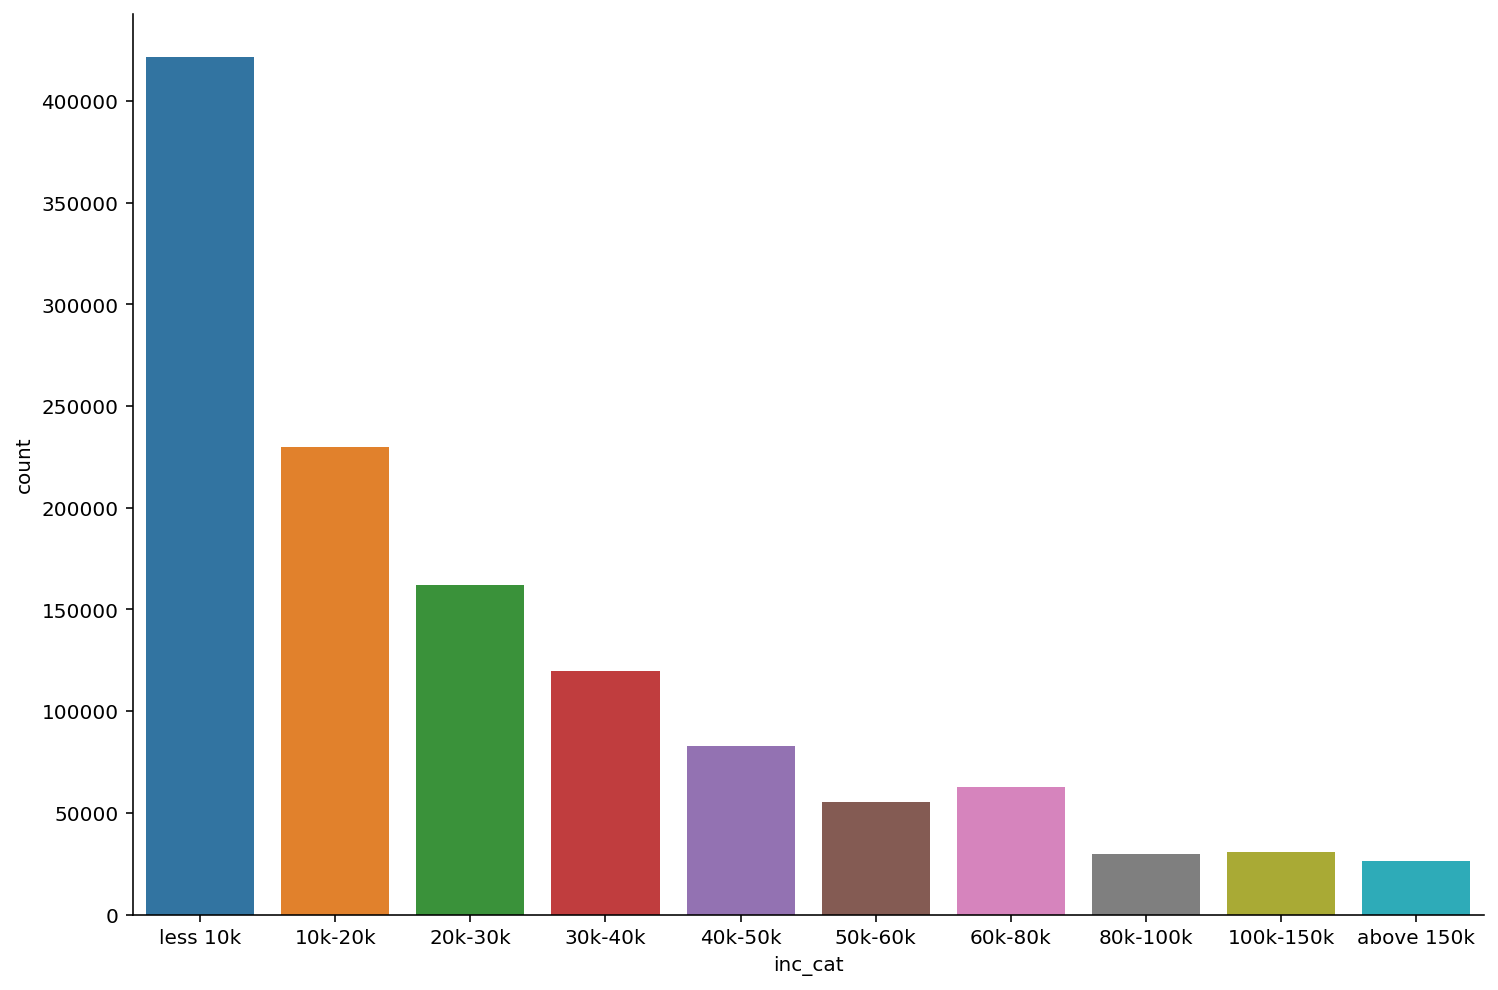

In [6]:
fig = sns.catplot(x="inc_cat", kind="count", data=df, height=7, aspect=1.5)
plt.show()

## Draw a sample for conducting the DP analysis

In [12]:
sample_size = 10000

# draw sample 
sample = df.sample(n = sample_size, random_state=0)
# save sample for DP analysis
col_names = [col for col in sample.columns]
sample.to_csv(samplefile, index=False, header=False)

We define two functions to support the further analysis:
1. `dp_histo` is used to generate data for the differentially private histograms for a given privacy parameter epsilon. It generates counts based on two alternative mechanisms to generate statistical noise: Geometric and Laplace.
2. `perc_error` is used to calculate the percentage deviation between the true and the differentially private distribution.

In [54]:
from opendp.measurements import *
from opendp.mod import enable_features, binary_search_chain, Measurement, Transformation
from opendp.transformations import *
from opendp.typing import *

# the greatest number of records that any one individual can influence in the dataset
max_influence = 1
# we can also reasonably intuit that age and income will be numeric,
#     as well as bounds for them, without looking at the data
age_bounds = (0, 100)
income_bounds = (0, 150_000)

budget = (0.1, 1e-8)

from opendp.mod import enable_features
enable_features('contrib', 'floating-point')

from opendp.transformations import make_split_dataframe, make_select_column

histogram = (
    # Convert data into a dataframe where columns are of type Vec<str>
    make_split_dataframe(separator=",", col_names=col_names) >>
    # Selects a column of df, Vec<str>
    make_select_column(key="inc_cat", TOA=str) >>
    make_count_by_categories(categories=income_categories)
)


geom_histogram = binary_search_chain(
    lambda s: histogram >> make_base_geometric(scale=s, D=VectorDomain[AllDomain[int]]),
    d_in=max_influence, d_out=budget[0])

#lap_histogram = binary_search_chain(
#    lambda s: histogram >>
#    make_cast_default(TIA=int, TOA=float) >>
#    make_base_laplace(scale=1.0),
#    d_in=max_influence, d_out=budget[0])

#hl1 = make_split_dataframe(separator=",", col_names=col_names) >> make_select_column(key="inc_cat", TOA=str)

#hl2 = hl1 >> make_count_by_categories(categories=income_categories)

#hl3 = hl2 >> make_cast_default(TIA=int, TOA=float) 

#hl4 = hl3 >> make_base_laplace(scale=1.0, D=VectorDomain[AllDomain[int]])


geom_histogram = (
    make_split_dataframe(separator=",", col_names=col_names) >>
    make_select_column(key="inc_cat", TOA=str) >>
    make_count_by_categories(categories=income_categories) >>
    make_base_geometric(scale=1.0, D=VectorDomain[AllDomain[int]])
)

lap_histogram = (
    make_split_dataframe(separator=",", col_names=col_names) >>
    make_select_column(key="inc_cat", TOA=str) >>
    make_count_by_categories(categories=income_categories) >>
    make_cast(TIA=int, TOA=float) >>
    make_base_laplace(scale=1.0, D=VectorDomain[AllDomain[float]])
)





def perc_error(true_col, dp_col):
    return sum(abs(true_col - dp_col)) / sum(true_col) * 100

OpenDPException: MetricMismatch("Intermediate metrics don't match. See https://github.com/opendp/opendp/discussions/297
    output_metric: L1Distance()
    input_metric:  SymmetricDistance()
")
	   0: backtrace::backtrace::trace
	   1: backtrace::capture::Backtrace::new_unresolved
	   2: _opendp_comb__make_chain_tt
	   3: _ffi_call_unix64
	   4: _ffi_call_int
	   5: __ctypes_callproc
	   6: _PyCFuncPtr_call
	   7: __PyObject_MakeTpCall
	   8: _call_function
	   9: __PyEval_EvalFrameDefault
	  10: __PyFunction_Vectorcall
	  11: _call_function
	  12: __PyEval_EvalFrameDefault
	  13: __PyFunction_Vectorcall
	  14: _slot_nb_rshift
	  15: _binary_op1
	  16: __PyEval_EvalFrameDefault
	  17: __PyEval_EvalCodeWithName
	  18: _builtin_exec
	  19: _cfunction_vectorcall_FASTCALL
	  20: _call_function
	  21: __PyEval_EvalFrameDefault
	  22: _gen_send_ex
	  23: __PyEval_EvalFrameDefault
	  24: _gen_send_ex
	  25: __PyEval_EvalFrameDefault
	  26: _gen_send_ex
	  27: _method_vectorcall_O
	  28: _call_function
	  29: __PyEval_EvalFrameDefault
	  30: __PyFunction_Vectorcall
	  31: _call_function
	  32: __PyEval_EvalFrameDefault
	  33: __PyFunction_Vectorcall
	  34: _call_function
	  35: __PyEval_EvalFrameDefault
	  36: __PyEval_EvalCodeWithName
	  37: __PyFunction_Vectorcall
	  38: _method_vectorcall
	  39: _PyVectorcall_Call
	  40: __PyEval_EvalFrameDefault
	  41: __PyEval_EvalCodeWithName
	  42: __PyFunction_Vectorcall
	  43: _method_vectorcall
	  44: _call_function
	  45: __PyEval_EvalFrameDefault
	  46: _gen_send_ex
	  47: __PyEval_EvalFrameDefault
	  48: _gen_send_ex
	  49: __PyEval_EvalFrameDefault
	  50: _gen_send_ex
	  51: __PyEval_EvalFrameDefault
	  52: _gen_send_ex
	  53: __PyEval_EvalFrameDefault
	  54: _gen_send_ex
	  55: _task_step
	  56: _TaskWakeupMethWrapper_call
	  57: __PyObject_MakeTpCall
	  58: _context_run
	  59: _cfunction_vectorcall_FASTCALL_KEYWORDS
	  60: _PyVectorcall_Call
	  61: __PyEval_EvalFrameDefault
	  62: __PyFunction_Vectorcall
	  63: _call_function
	  64: __PyEval_EvalFrameDefault
	  65: __PyFunction_Vectorcall
	  66: _call_function
	  67: __PyEval_EvalFrameDefault
	  68: __PyFunction_Vectorcall
	  69: _call_function
	  70: __PyEval_EvalFrameDefault
	  71: __PyFunction_Vectorcall
	  72: _call_function
	  73: __PyEval_EvalFrameDefault
	  74: __PyFunction_Vectorcall
	  75: _call_function
	  76: __PyEval_EvalFrameDefault
	  77: __PyEval_EvalCodeWithName
	  78: __PyFunction_Vectorcall
	  79: _method_vectorcall
	  80: _call_function
	  81: __PyEval_EvalFrameDefault
	  82: __PyEval_EvalCodeWithName
	  83: _builtin_exec
	  84: _cfunction_vectorcall_FASTCALL
	  85: _call_function
	  86: __PyEval_EvalFrameDefault
	  87: __PyEval_EvalCodeWithName
	  88: __PyFunction_Vectorcall
	  89: _call_function
	  90: __PyEval_EvalFrameDefault
	  91: __PyEval_EvalCodeWithName
	  92: __PyFunction_Vectorcall
	  93: _PyVectorcall_Call
	  94: _pymain_run_module
	  95: _pymain_run_python
	  96: _Py_RunMain
	  97: _pymain_main
	  98: _main
	

In [29]:
with open(samplefile) as input_data:
    data = input_data.read()

actual = histogram(data)
geo_counts = geom_histogram(data) 

print("Income histogram actual counts:   " + str(actual))
print("Income histogram Geometric DP release:   " + str(geo_counts))
#print("Income histogram Laplace DP release:     " + str(laplace_counts.astype(int)))

# Clarify meaning of 11th value (bins = 10)

Income histogram actual counts:   [3410, 1849, 1316, 992, 656, 494, 518, 279, 257, 229, 0]
Income histogram Geometric DP release:   [3420, 1859, 1316, 999, 658, 487, 518, 288, 262, 223, 19]


In [ ]:
results = pd.DataFrame(index=income_categories)
private_df = pd.read_csv(samplefile)
results['True'] = private_df['inc_cat'].value_counts()
results['Geom-DP'] = geo_counts[:len(income_categories)]
results['Lapl-DP'] = laplace_counts[:len(income_categories)].astype(int)

results

In [ ]:
error_geom = perc_error(results['True'], results['Geom-DP'])
error_lapl = perc_error(results['True'], results['Lapl-DP'])

print ('Geometric DP mechanism with ε = ' + str(epsilon) + ' : Deviation compared to non-private sample  = ' + str(round(error_geom,1)) +'%')
print ('Laplace DP mechanism with ε = ' + str(epsilon) + ' : Deviation compared to non-private sample = ' + str(round(error_lapl,1)) +'%')

## Assessing the impact of privacy guarantee and amount of data on accuracy
We will generate histograms for various sample sizes. Each histogram compares the data from the original distribution with differentially private counts at different privacy levels (controlled by the privacy parameter ε). Low values of ε are associated with higher privacy guarantees and therefore higher amounts of statistical noise. The following charts can be used to develop an intuition for the tradeoff between privacy and accuracy.
Furthermore, we will see how the loss in accuracy can be compensated by increasing the sample size. Feel free to adjust `sample_sizes` and `epsilons` in the cell below to investigate different settings.

In [ ]:
sample_sizes = [10000, 50000, 200000]
epsilons = [0.5, 0.1, 0.05]

for sample_size in sample_sizes:
    # draw sample 
    sample = df.sample(n = sample_size, random_state=0)
    # save sample for DP analysis
    sample.to_csv(samplefile, index=False)

    results = pd.DataFrame(index=income_categories)
    private_df = pd.read_csv(samplefile)
    results['True'] = private_df['inc_cat'].value_counts()

    labels = ['True value from original sample']
    
    for epsilon in epsilons:
        geo_counts, laplace_counts = dp_histo(epsilon)

        results['Geom-DP-'+str(epsilon)] = geo_counts[:len(income_categories)]
               
        error = perc_error(results['True'], results['Geom-DP-'+str(epsilon)])
            
        labels.append('DP with ε = ' + str(epsilon) + ' : Error = ' + str(round(error,1)) + '%')

    ax = results.plot.bar(rot=45, figsize=(13, 8), width=0.8, fontsize=12, colormap = 'Accent')
    plt.title('Income Distribution (n = '+str(sample_size)+')', fontsize=16)
    plt.legend(fontsize = 12, labels=labels)
    plt.grid(axis='y', alpha=0.5)
    plt.ylabel('Count', fontsize = 14)
    plt.ylim(-50)
    plt.show()